In [58]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

plt.style.use('ggplot')

In [59]:
train_df = pd.read_csv("data/train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [60]:
X = train_df.drop(["Survived","Cabin", "Ticket", "Name", "PassengerId"], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [61]:
y = train_df["Survived"]

In [62]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [63]:
for col in ["Sex", "Embarked"]:
    print(f"{col}:\t{X[col].unique()}")

Sex:	['male' 'female']
Embarked:	['S' 'C' 'Q' nan]


In [64]:
X["Embarked"] = X["Embarked"].map({"Q":0, "S":1, "C":2})
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,1.0
1,1,female,38.0,1,0,71.2833,2.0
2,3,female,26.0,0,0,7.9250,1.0
3,1,female,35.0,1,0,53.1000,1.0
4,3,male,35.0,0,0,8.0500,1.0


In [65]:
X["Sex"] = X["Sex"].map({"male":0, "female":1})

In [66]:
X.isnull().any()

Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
Embarked     True
dtype: bool

In [67]:
X["Age"] = X["Age"].fillna(X["Age"].median())

In [68]:
X["Embarked"] = X["Embarked"].fillna(X["Embarked"].median())

In [69]:
X.isnull().any()

Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Embarked    False
dtype: bool

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1515)

In [71]:
X_train.shape, y_train.shape

((623, 7), (623,))

In [72]:
X_test.shape, y_test.shape

((268, 7), (268,))

In [73]:
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)

RandomForestClassifier()

In [74]:
y_pred = RFC.predict(X_test)
y_pred_prob = RFC.predict_proba(X_test) 

In [75]:
metrics.accuracy_score(y_test, y_pred)

0.8395522388059702

In [76]:
exp=shap.TreeExplainer(RFC)
sv_test = exp.shap_values(X_test)
sv_test = sv_test[1]
sv_test.shape

(268, 7)

In [77]:
exp.expected_value[1] + sv_test[0].sum(), y_pred_prob[0]

(0.15565792540792622, array([0.84434207, 0.15565793]))

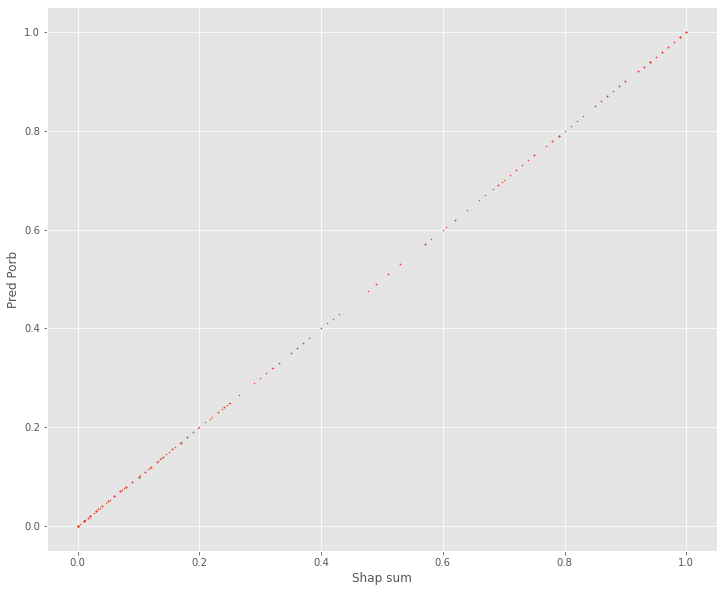

In [78]:
sv_sum = sv_test.sum(axis=1) + exp.expected_value[1]
plt.scatter(sv_sum, y_pred_prob[:,1], s=1)
plt.xlabel("Shap sum")
plt.ylabel("Pred Porb")
plt.savefig("fig/Pred_prob.png")

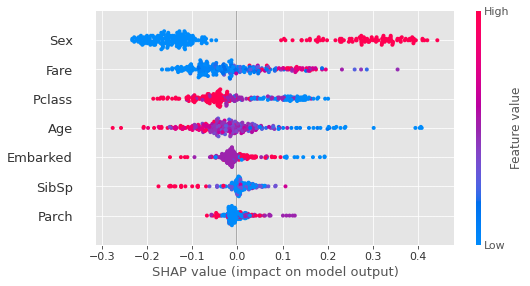

In [79]:
fig = shap.summary_plot(sv_test, X_test, show=False)
plt.savefig("fig/summary_plot.png")

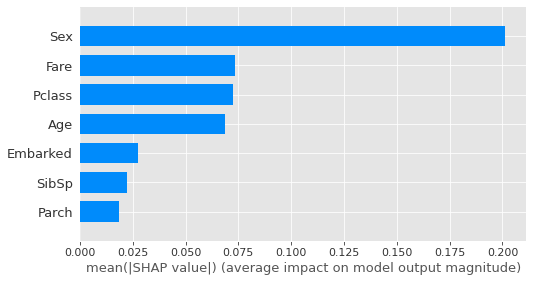

In [80]:
fig = shap.summary_plot(sv_test, X_test, plot_type="bar", show=False)
plt.savefig("fig/summary_bar.png")

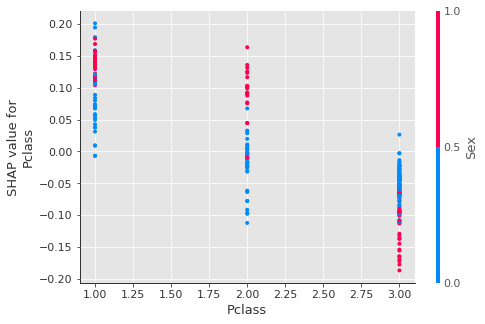

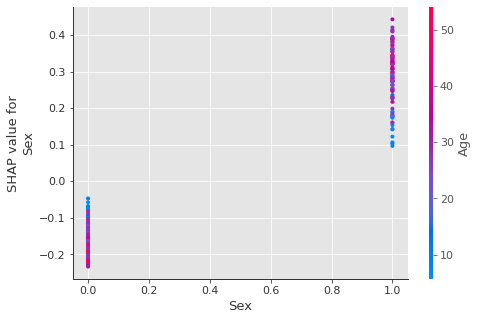

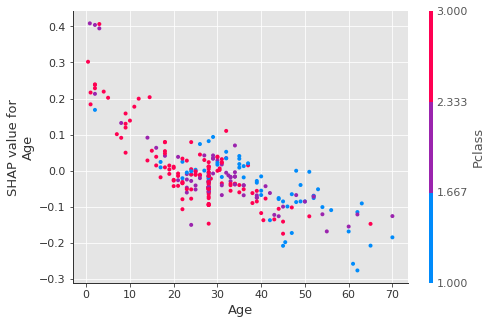

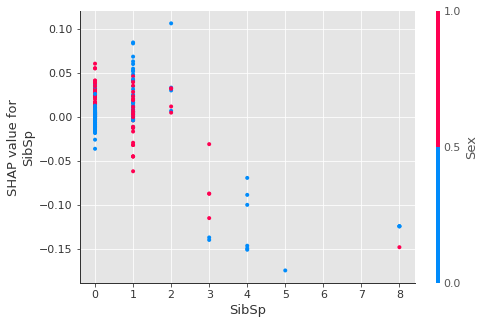

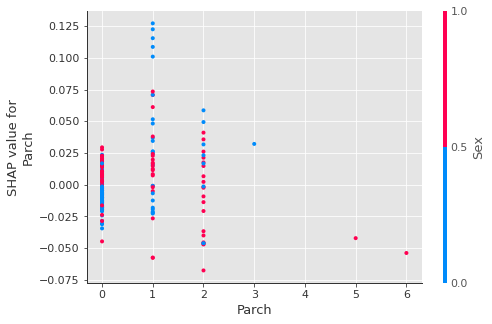

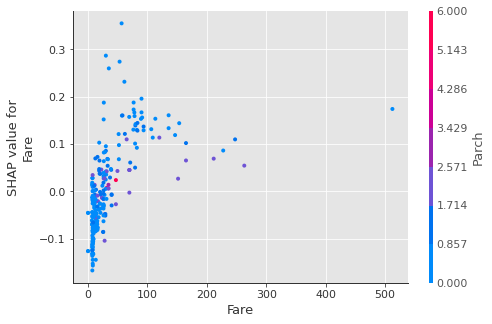

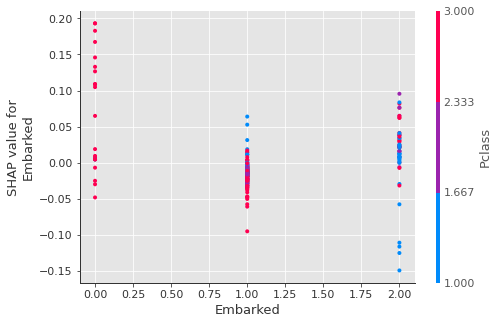

In [81]:
fea_list = X_test.columns

for idx, v in enumerate(fea_list):
    fig = shap.dependence_plot(v, sv_test, X_test, show=False)
    plt.savefig(f"fig/depend_{v}.png")

In [89]:
num = X_test.shape[0]
shap.initjs()
shap.force_plot(exp.expected_value[1], sv_test[:num], X_test.iloc[:num], plot_cmap="Jet")

In [105]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
labels = kmeans.fit_predict(sv_test)
pd.value_counts(labels)

3    129
4     52
1     40
0     27
2     20
dtype: int64

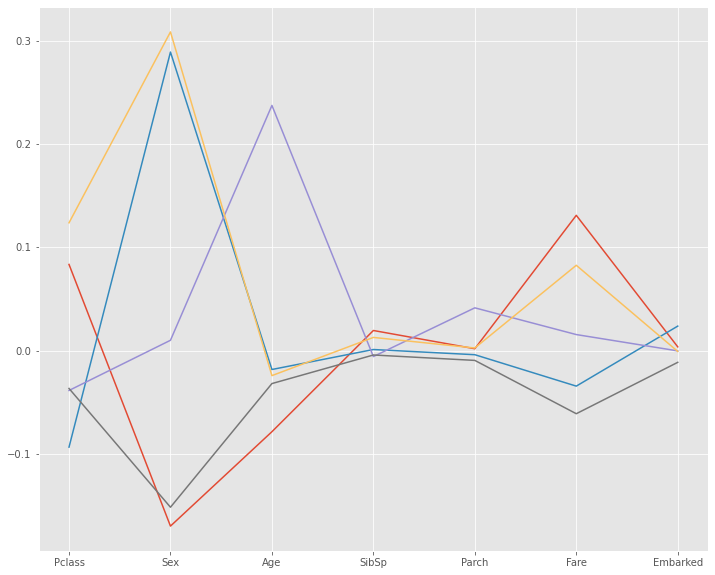

In [106]:
center = pd.DataFrame(kmeans.cluster_centers_, columns=X_test.columns).T
plt.plot(center)

In [108]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit_transform(sv_test)
pca.explained_variance_ratio_

array([0.64410469, 0.15049062, 0.12671957, 0.03571706, 0.02272521])

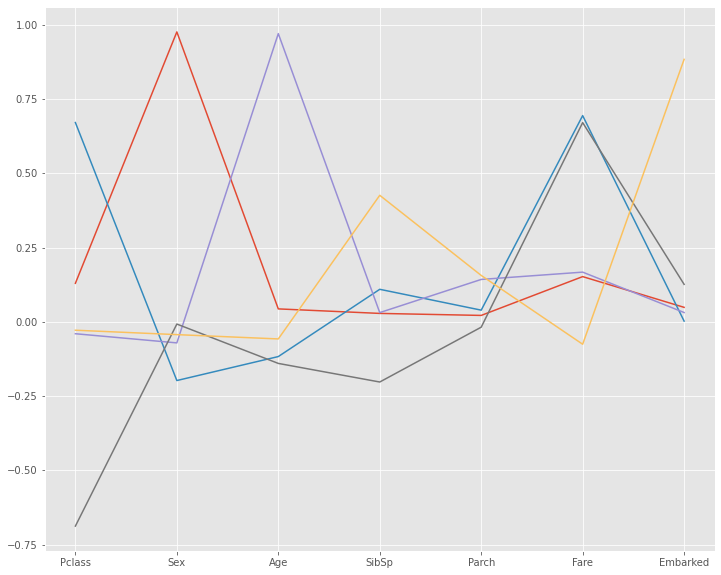

In [112]:
comp = pd.DataFrame(pca.components_, columns=X.columns).T
comp.plot(subplots=True, sharey=True)
# plt.plot(comp)

In [123]:
exp_new = shap.TreeExplainer(RFC)

In [125]:
X_test, X_new = X_test.iloc[:-50], X_test.iloc[-50:]
X_test.shape, X_new.shape

((68, 7), (50, 7))

In [126]:
sv_test = exp_new.shap_values(X_test)[1]
sv_future = exp_new.shap_values(X_new)[1]

In [127]:
sv_test.shape, sv_future.shape

((68, 7), (50, 7))

In [133]:

N = sv_test.shape[0]
M = sv_future.shape[0]
D = sv_test.shape[1]

dist = np.linalg.norm(sv_test.reshape(N,-1,D) - sv_future.reshape(-1,M,D), axis=2)
near = np.argmin(dist, axis=0)

near

array([ 3, 20, 51, 32, 67, 45, 59, 64, 48, 54, 11, 26,  7, 54, 58, 23, 12,
       60, 58,  5, 45, 67, 19, 22, 48, 24, 64, 16, 44, 23, 25, 19,  5, 19,
       28, 51, 40, 25, 20, 20, 20, 20,  2, 56,  5,  3, 42,  7, 21, 24],
      dtype=int64)

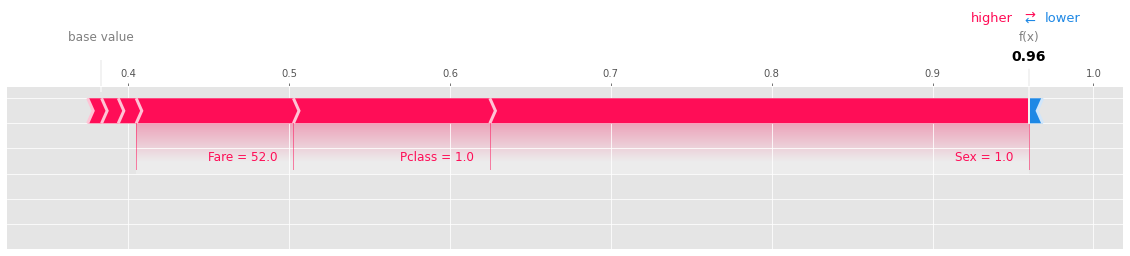

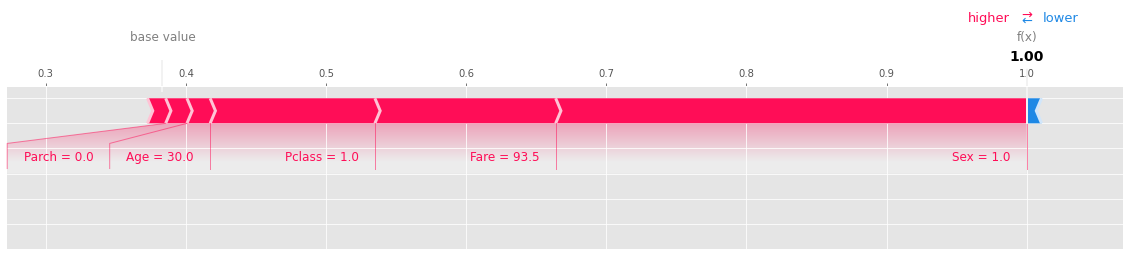

In [137]:
i = 2
shap.force_plot(exp.expected_value[1], sv_future[i], X_new.iloc[i], matplotlib=True)
shap.force_plot(exp.expected_value[1], sv_test[near[i]], X_test.iloc[near[i]], matplotlib=True)


In [117]:
from sklearn.neighbors import LocalOutlierFactor
outlier = LocalOutlierFactor(n_neighbors=20, novelty=True)
outlier.fit(sv_test)
score = outlier.score_samples(sv_test)

In [119]:
index = np.argmin(score)
index

77

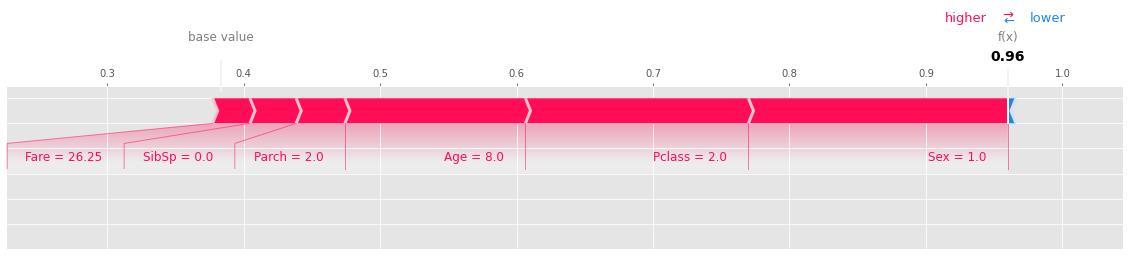